In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Preprocessing the data

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("snicolau/bdb_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/469 [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/674 [00:00<?, ? examples/s]

In [ ]:
bdb_dataset = dataset["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)
bdb_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 606
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 68
    })
})

In [ ]:
from transformers import AutoFeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [ ]:
sampling_rate = feature_extractor.sampling_rate

In [ ]:
from datasets import Audio

bdb_dataset = bdb_dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [ ]:
import numpy as np

sample = bdb_dataset["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: 0.00415, Variance: 0.0452


In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: 2.74e-09, Variance: 1.0


In [ ]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
bdb_dataset_encoded = bdb_dataset.map(
    preprocess_function,
    remove_columns=["audio"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
bdb_dataset_encoded

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 606
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 68
    })
})

In [ ]:
# Replace this with your custom dataset's class names
class_names = ["bolero", "fandango_mall", "fandango_men", "jota", "mateixa"]

# Define id2label and label2id mappings
id2label = {str(i): class_name for i, class_name in enumerate(class_names)}
label2id = {v: k for k, v in id2label.items()}

## Test model

In [ ]:
import torch
from transformers import AutoModelForAudioClassification, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 1. Load your model from Hugging Face
def load_model_and_tokenizer(model_name_or_path):
    model = AutoModelForAudioClassification.from_pretrained(model_name_or_path)
    return model

# 2. Prepare the dataset
def preprocess_dataset(dataset, tokenizer, audio_column, label_column, max_length):
    def preprocess_function(examples):
        audio_features = examples[audio_column]
        labels = examples[label_column]
        inputs = tokenizer(audio_features, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        inputs["labels"] = torch.tensor(labels, dtype=torch.long)  # For multi-class classification
        return inputs

    return dataset.map(preprocess_function, batched=True)

# 3. Perform inference
def evaluate_model_old(model, dataset, batch_size=8):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i+batch_size]
            inputs = {key: torch.stack([example[key] for example in batch]) for key in batch[0].keys() if key != "labels"}
            labels = torch.stack([example["labels"] for example in batch])
            outputs = model(**inputs)
            logits = outputs.logits

            predictions.extend(torch.softmax(logits, dim=-1).cpu().numpy())  # Softmax for multi-class
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

def evaluate_model(model, dataset, batch_size=8):
    model.eval()
    predictions, true_labels = [], []

    # Convert dataset to PyTorch format
    dataset.set_format(type="torch", columns=[col for col in dataset.column_names if col != "label"] + ["label"])

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i + batch_size]
            inputs = {key: batch[key] for key in batch.keys() if key != "label"}
            labels = batch["label"]

            outputs = model(**inputs)
            logits = outputs.logits

            predictions.extend(torch.softmax(logits, dim=-1).cpu().numpy())  # Softmax for multi-class
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)


# 4. Analyze results
def analyze_results(predictions, true_labels, class_names):
    predicted_classes = np.argmax(predictions, axis=-1)
    report = classification_report(true_labels, predicted_classes, zero_division=0, target_names=class_names)
    conf_matrix = confusion_matrix(true_labels, predicted_classes, normalize='true')  # Normalize by true class samples

    return report, conf_matrix

In [ ]:
model_name = "snicolau/distilhubert-finetuned-bdb"

# Load model and tokenizer
model = load_model_and_tokenizer(model_name)

# Load test dataset
test_dataset = bdb_dataset_encoded['test']

# Evaluate model
predictions, true_labels = evaluate_model(model, test_dataset)

Classification Report:
               precision    recall  f1-score   support

       bolero       0.80      1.00      0.89         8
fandango_mall       0.77      0.77      0.77        13
 fandango_men       0.56      0.62      0.59         8
         jota       0.97      0.80      0.88        35
      mateixa       0.43      0.75      0.55         4

     accuracy                           0.79        68
    macro avg       0.70      0.79      0.73        68
 weighted avg       0.83      0.79      0.80        68


Confusion Matrix:


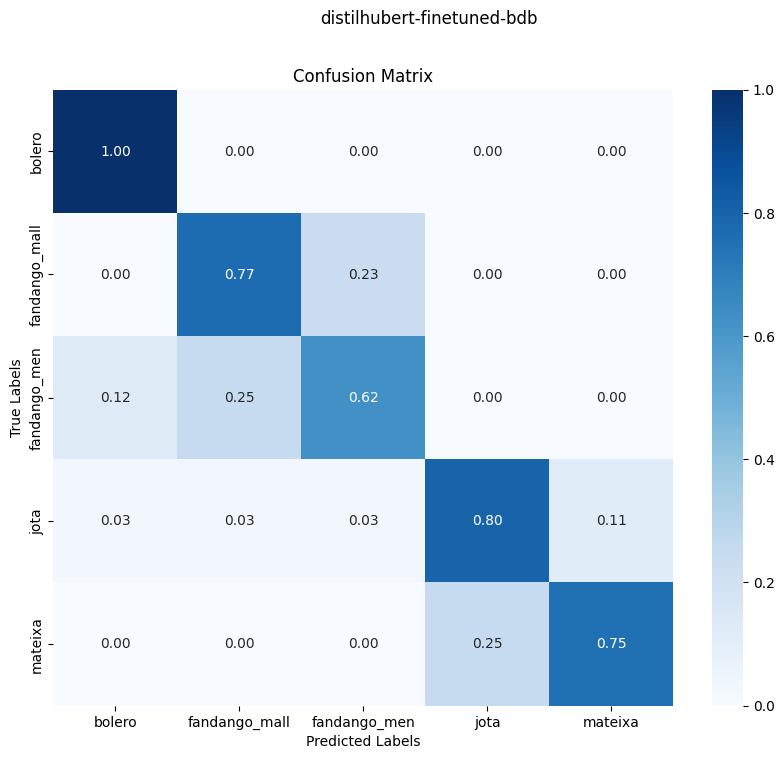

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze results
class_names = ["bolero", "fandango_mall", "fandango_men", "jota", "mateixa"]
report, conf_matrix = analyze_results(predictions, true_labels, class_names)

print("Classification Report:")
print(report)

print("\nConfusion Matrix:")
# print(pd.DataFrame(conf_matrix, index=[f"Actual {i}" for i in range(conf_matrix.shape[0])],
#                     columns=[f"Predicted {i}" for i in range(conf_matrix.shape[1])]))

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.suptitle("distilhubert-finetuned-bdb")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)